# Lab 3: Titan AO

In [1]:
import os 
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.background import LocalBackground, MedianBackground
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from scipy.optimize import curve_fit

import astroalign
%matplotlib widget

### 1. Data Reduction

In [3]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\AO"

In [4]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [5]:
# Keys to sort fits files 
frame_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    frame_lst[i] = hdu_lst[i].header['FRAMENUM']

print('filenames', np.unique(frame_lst))

filenames ['153' '154' '155' '156' '157' '158' '159' '160' '161' '162' '177' '178'
 '179' '180' '181' '182' '183' '184' '186' '187' '188' '189' '190' '191'
 '1918' '1919' '192' '1920' '1921' '1922' '1923' '1924' '1925' '1926'
 '1927' '1928' '1929' '193' '1930' '1931' '1932' '1933' '1934' '1936'
 '1937' '1938' '1939' '194' '1940' '1941' '1942' '195' '196' '197' '198'
 '227' '228' '229' '230' '231' '232' '233' '234' '235' '236' '237' '238'
 '239' '240' '241' '242' '243' '244' '245' '246' '247' '248' '249' '250'
 '251' '252' '253' '255' '256' '257' '259' '260' '261' '262' '263' '264'
 '265' '266' '355' '356' '357' '358' '359' '360' '361' '362' '363' '364'
 '365' '366' '367' '368' '369' '370' '371' '372']


In [6]:
titan_k_ch4 = [str(a) for a in range(355,359)]
titan_j_ch4 = [str(a) for a in range(362,366)]
titan_feII = [str(a) for a in range(366,370)]

domeFlat_k_ch4 = [str(a) for a in range(188,199)]
domeFlat_j_ch4 = [str(a) for a in range(177,188)]
domeFlat_feII  = [str(a) for a in range(153,164)]

darks = [str(a) for a in range(227,267)]
for a in range(1918,1943):
    darks.append(str(a))

titanSky_feII  = '370'
titanSky_k_ch4 = '371'
titanSky_j_ch4 = '372'

In [7]:
frame_lst

array(['153', '154', '155', '156', '157', '158', '159', '160', '161',
       '162', '162', '177', '178', '179', '180', '181', '182', '183',
       '184', '184', '186', '187', '188', '189', '190', '191', '192',
       '193', '194', '195', '196', '197', '198', '227', '228', '229',
       '230', '231', '232', '233', '234', '235', '236', '237', '238',
       '239', '240', '241', '242', '243', '244', '245', '246', '247',
       '248', '249', '250', '251', '252', '253', '253', '255', '256',
       '257', '257', '259', '260', '261', '262', '263', '264', '265',
       '266', '355', '356', '357', '358', '359', '360', '361', '362',
       '363', '364', '365', '366', '367', '368', '369', '370', '371',
       '372', '1918', '1919', '1920', '1921', '1922', '1923', '1924',
       '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932',
       '1933', '1934', '1934', '1936', '1937', '1938', '1939', '1940',
       '1941', '1942'], dtype=object)

In [8]:
domeFlat_feII

['153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163']

In [9]:
np.where([a == frame_lst for a in darks])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 26, 28, 29, 30, 30, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 56, 58, 59, 60, 61, 62, 63, 64],
       dtype=int64),
 array([ 33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115],
       dtype=int64))

In [10]:
titan_kch4_frames = hdu_lst[np.where([a == frame_lst for a in titan_k_ch4])[1]]
titan_jch4_frames = hdu_lst[np.where([a == frame_lst for a in titan_j_ch4])[1]]
titan_feII_frames = hdu_lst[np.where([a == frame_lst for a in titan_feII])[1]]

domeFlat_kch4_frames = hdu_lst[np.where([a == frame_lst for a in domeFlat_k_ch4])[1]]
domeFlat_jch4_frames = hdu_lst[np.where([a == frame_lst for a in domeFlat_j_ch4])[1]]
domeFlat_feII_frames = hdu_lst[np.where([a == frame_lst for a in domeFlat_feII])[1]]

dark_frames = hdu_lst[np.where([a == frame_lst for a in darks])[1]]

titan_feII_frames = np.append(titan_feII_frames, hdu_lst[np.where(titanSky_feII == frame_lst)])
titan_kch4_frames = np.append(titan_kch4_frames, hdu_lst[np.where(titanSky_k_ch4 == frame_lst)])
titan_jch4_frames = np.append(titan_jch4_frames, hdu_lst[np.where(titanSky_j_ch4 == frame_lst)])

In [193]:
for t in titan_feII_frames:
    print(t.header['TIME-OBS'])

18:22:25.531
18:24:24.734
18:26:08.953
18:28:07.828
18:30:55.531


In [11]:
dark_exptimes = np.array([i.header['TRUITIME'] for i in dark_frames])
dark_5 = dark_frames[np.where(dark_exptimes == 5.81916)]
dark_7 = dark_frames[np.where(dark_exptimes == 7.27395)] 
dark_4 = dark_frames[np.where(dark_exptimes == 4.36437)]
dark_60 = dark_frames[np.where(dark_exptimes == 59.64639)]
dark_90 = dark_frames[np.where(dark_exptimes == 88.74219)]

In [31]:
dark_4

array([<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000029D2BE28190>,
      dtype=object)

In [12]:
# Define crop regions
reg1 = [(1000,1300),(600,900)]
reg =  [(450,1100),(900,1400)] # Detector region 

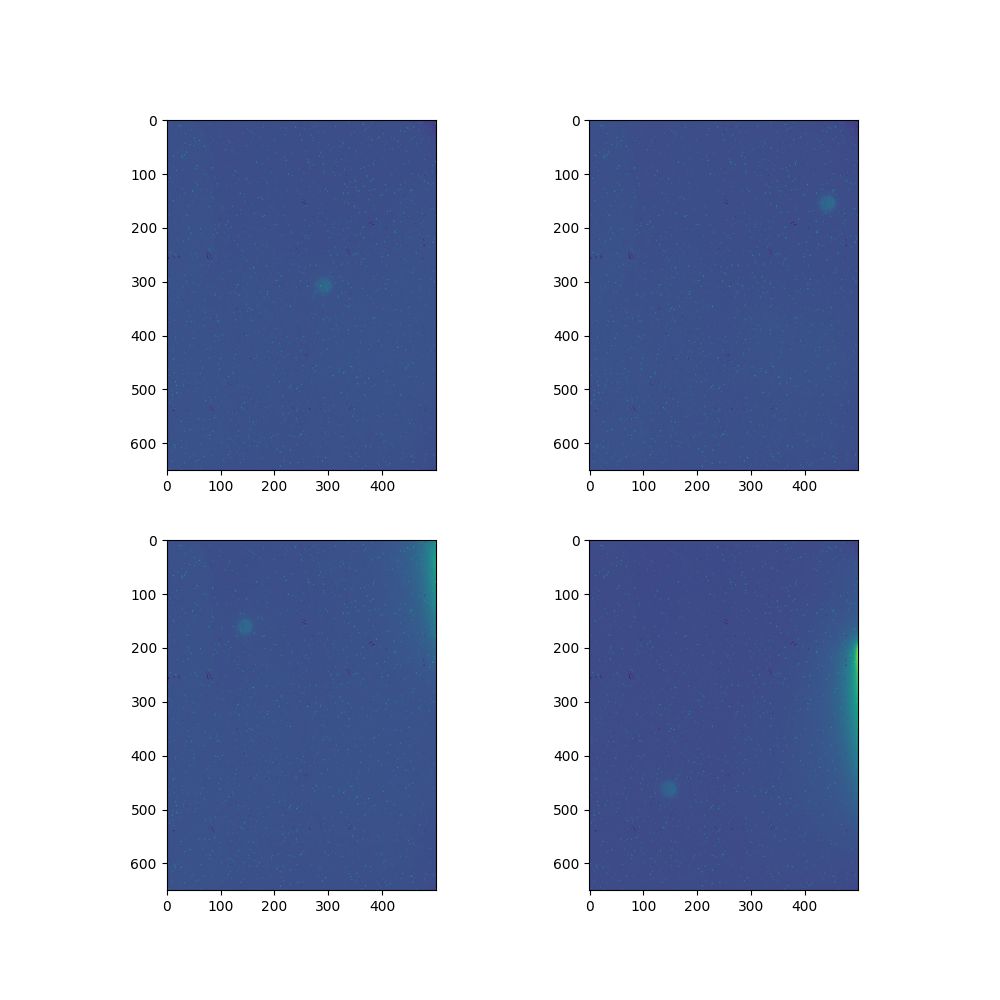

In [13]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(titan_kch4_frames[0].data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]])
ax[0,1].imshow(titan_kch4_frames[1].data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1] ])
ax[1,0].imshow(titan_kch4_frames[2].data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1] ])
ax[1,1].imshow(titan_kch4_frames[3].data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1] ])

In [14]:
df_dict = {'J':dark_5, 'K':dark_7,'Fe':dark_4}
sci_dict = {'J':dark_60, 'K':dark_90,'Fe':dark_60}
def reduce_data2(dark, dome_flat, science, reg, filter):

    # Median Bias Frames
    # bias_full = np.median(np.stack([b.data for b in bias]),axis=0)

    # Median Dark Frames 
    # dark_exptime = dark[0].header['EXPTIME']
    dark_full = np.median(np.stack([(b.data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]])/b.header['TRUITIME'] for b in dark]),axis=0)

    dark_df = np.median(np.stack([(b.data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]])/b.header['TRUITIME'] for b in df_dict[filter]]),axis=0)
    dark_sci = np.median(np.stack([(b.data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]])/b.header['TRUITIME'] for b in sci_dict[filter]]),axis=0)

    # Median Dome Flats
    # df_exptime = dome_flat[0].header['EXPTIME']
    dome_flat_full = np.median(np.stack([(((b.data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]])/b.header['TRUITIME']) - (dark_df))/np.median(b.data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]]) for b in dome_flat]), axis=0)
    
    # Median Science Frames
    # sci_exptime = science[0].header['EXPTIME']
    sci_full = [(((b.data[reg[0][0]:reg[0][1],reg[1][0]:reg[1][1]])/b.header['TRUITIME']) - (dark_sci))/dome_flat_full for b in science]

    # print(f"Exposure Times:\nDome Flat - {df_exptime}s\nDark - {dark_exptime}s\nScience - {sci_exptime}s\n")
    return sci_full
    

In [15]:
red_feII = reduce_data2(dark_frames, domeFlat_feII_frames, titan_feII_frames, reg,'Fe')
red_kch4 = reduce_data2(dark_frames, domeFlat_kch4_frames, titan_kch4_frames, reg, 'K')
red_jch4 = reduce_data2(dark_frames, domeFlat_jch4_frames, titan_jch4_frames, reg, 'J')

In [74]:
def plot_red(res):
    fig, ax = plt.subplots(3,2,figsize=(10,10))
    ax[0,0].imshow(res[0],vmin=np.nanpercentile(res[0],3),vmax=np.nanpercentile(res[0],99.9))
    ax[0,1].imshow(res[1],vmin=np.nanpercentile(res[1],3),vmax=np.nanpercentile(res[1],99.9))
    ax[1,0].imshow(res[2],vmin=np.nanpercentile(res[2],3),vmax=np.nanpercentile(res[2],99.9))
    ax[1,1].imshow(res[3],vmin=np.nanpercentile(res[3],3),vmax=np.nanpercentile(res[3],99.9))
    ax[2,0].imshow(res[4],vmin=np.nanpercentile(res[4],3),vmax=np.nanpercentile(res[4],99.9))

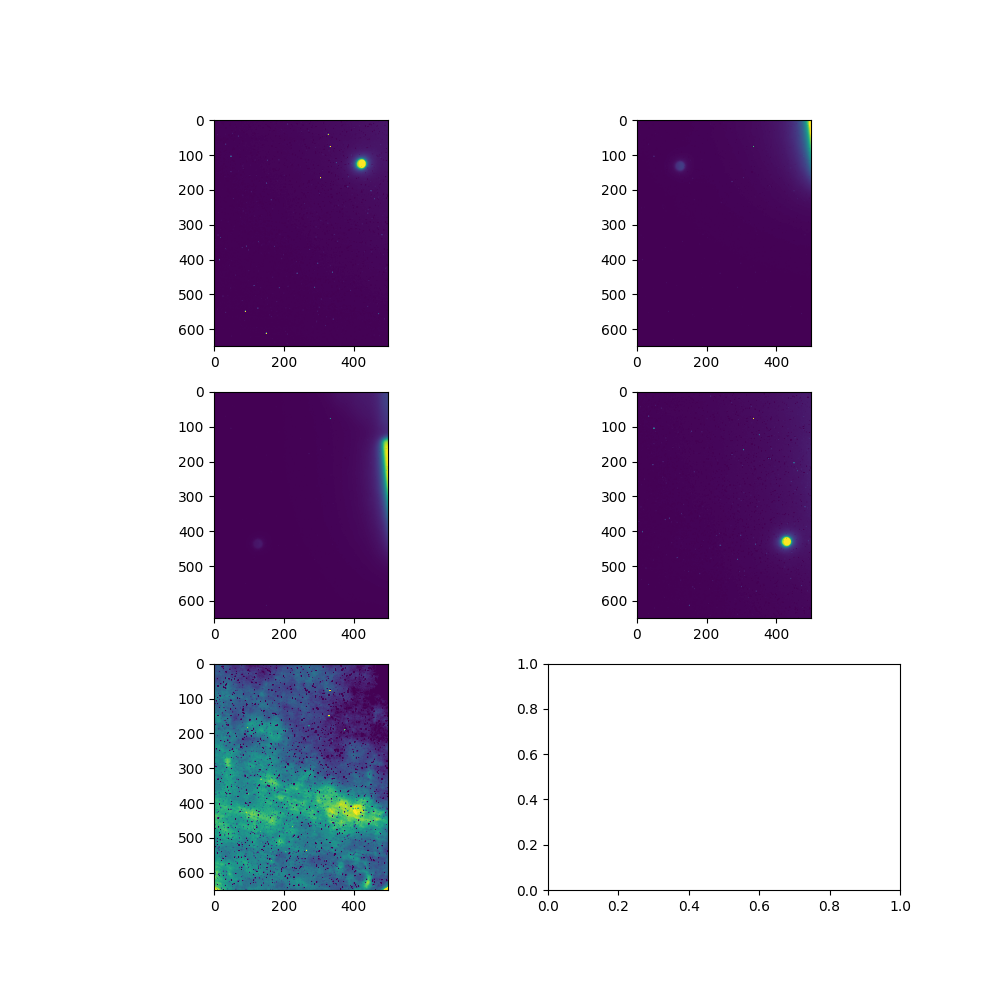

In [169]:
plot_red(red_jch4)

In [20]:
def plot_ditherings(d1, d2, dsum):
    fig, ax = plt.subplots(1,3,figsize=(12,5))
    a = ax[0].imshow(d1,vmin=np.nanpercentile(d1,3),vmax=np.nanpercentile(d1,99.9),cmap='bwr')
    b = ax[1].imshow(d2,vmin=np.nanpercentile(d2,3),vmax=np.nanpercentile(d2,99.9),cmap='bwr')
    c = ax[2].imshow(dsum,vmin=np.nanpercentile(dsum,3),vmax=np.nanpercentile(dsum,99.9),cmap='bwr')
    fig.colorbar(a, ax=ax[0], fraction=0.046, pad=0.08, orientation='horizontal', location='bottom')
    fig.colorbar(b, ax=ax[1], fraction=0.046, pad=0.08, orientation='horizontal', location='bottom')
    fig.colorbar(c, ax=ax[2], fraction=0.046, pad=0.08, orientation='horizontal', location='bottom')


In [176]:
dither_jch4   = red_jch4[0] - np.median(red_jch4[3],axis=0)
dither_jch4_2 = red_jch4[3] - np.median(red_jch4[0],axis=0)
dither_jch4_3 = red_jch4[1][:,0:300] - np.median(np.stack([red_jch4[i][:,0:300] for i in [0,2,3]]),axis=0)
dither_jch4_4 = red_jch4[2][:,0:300] - np.median(np.stack([red_jch4[i][:,0:300] for i in [0,1,3]]),axis=0)


dreg_jch4 = [(80,180),(370,480)]
dreg2_jch4 = [(380,480),(378,488)]
dreg3_jch4 = [(82,182),(70,180)]
dreg4_jch4 = [(385,485),(70,180)]


dither_jch4_1 = dither_jch4[dreg_jch4[0][0]:dreg_jch4[0][1], dreg_jch4[1][0]:dreg_jch4[1][1]]
dither_jch4_2 = dither_jch4_2[dreg2_jch4[0][0]:dreg2_jch4[0][1], dreg2_jch4[1][0]:dreg2_jch4[1][1]]
dither_jch4_3 = dither_jch4_3[dreg3_jch4[0][0]:dreg3_jch4[0][1], dreg3_jch4[1][0]:dreg3_jch4[1][1]]
dither_jch4_4 = dither_jch4_4[dreg4_jch4[0][0]:dreg4_jch4[0][1], dreg4_jch4[1][0]:dreg4_jch4[1][1]]

dither_jch4_1 = np.ma.masked_where((0 > dither_jch4_1 ) | (dither_jch4_1 > 1), dither_jch4_1)
dither_jch4_2 = np.ma.masked_where((0 > dither_jch4_2 ) | (dither_jch4_2 > 1), dither_jch4_2)
dither_jch4_3 = np.ma.masked_where((0 > dither_jch4_3 ) | (dither_jch4_3 > 1), dither_jch4_3)
dither_jch4_4 = np.ma.masked_where((0 > dither_jch4_4 ) | (dither_jch4_4 > 1), dither_jch4_4)


dither_jch4 =dither_jch4_3.data + dither_jch4_4.data #  dither_jch4_1.data + dither_jch4_2.data + 

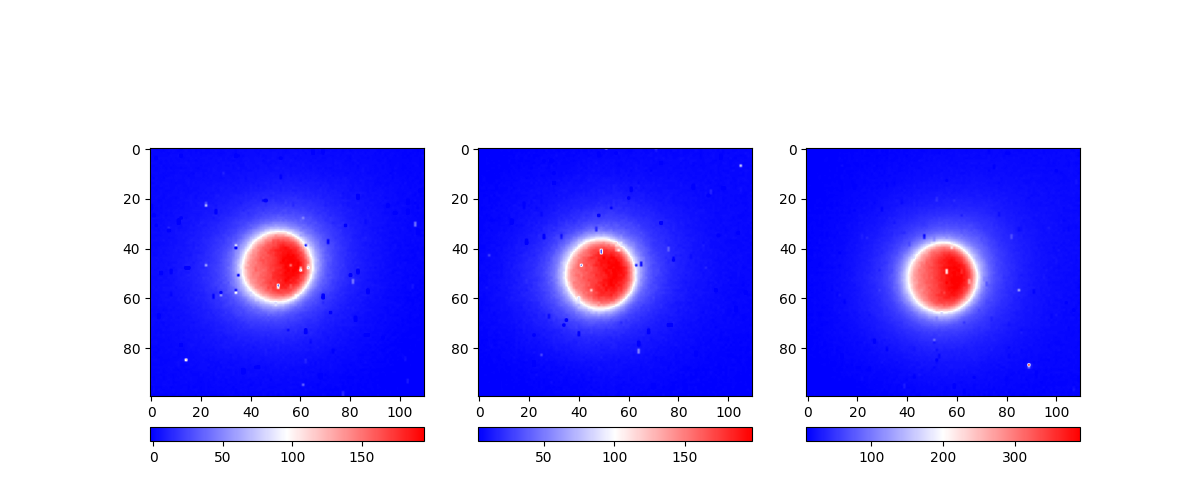

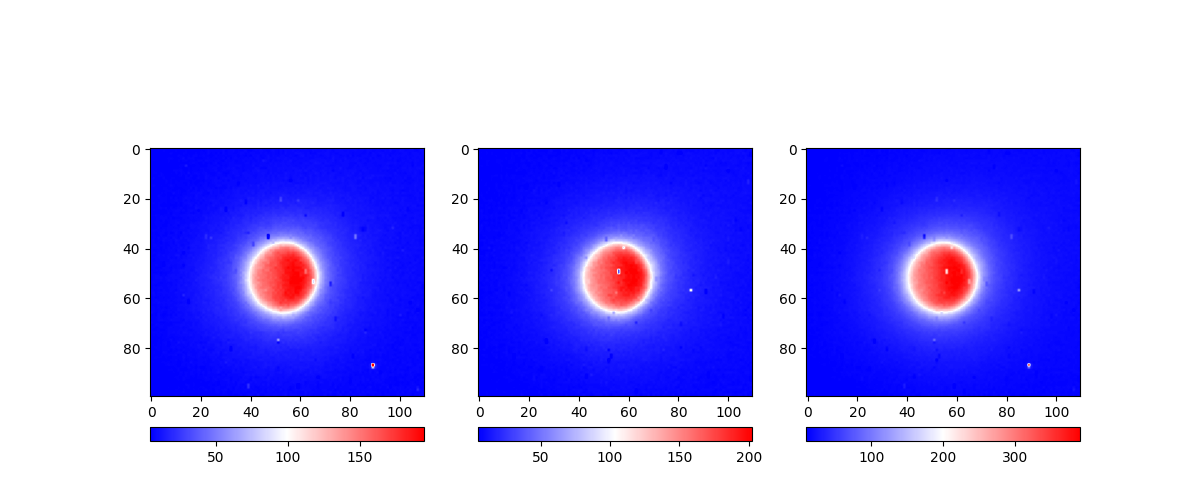

In [177]:
plot_ditherings(dither_jch4_1.data, dither_jch4_2.data, dither_jch4)
plot_ditherings(dither_jch4_3.data, dither_jch4_4.data, dither_jch4)

In [132]:
dither_kch4 = red_kch4[0] - np.median(np.stack([red_kch4[1], red_kch4[4]]),axis=0)
dither_kch4_2 = red_kch4[1] - np.median(np.stack([red_kch4[0], red_kch4[4]]),axis=0)
dither_kch4_3 = red_kch4[2][:,:210] - np.median(np.stack([red_kch4[i][:,:210] for i in [0,1,3,4]]),axis=0)
dither_kch4_4 = red_kch4[3][:,:210] - np.median(np.stack([red_kch4[i][:,:210] for i in [0,1,2,4]]),axis=0)


dreg_kch4 = [(250,350),(240,350)]
dreg2_kch4 = [(100,200),(390,530)]
dreg3_kch4 = [(110,210),(95,205)]
dreg4_kch4 = [(410,510),(95,205)]


dither_kch4_1 = dither_kch4[dreg_kch4[0][0]:dreg_kch4[0][1], dreg_kch4[1][0]:dreg_kch4[1][1]]
dither_kch4_2 = dither_kch4_2[dreg2_kch4[0][0]:dreg2_kch4[0][1], dreg2_kch4[1][0]:dreg2_kch4[1][1]]
dither_kch4_3 = dither_kch4_3[dreg3_kch4[0][0]:dreg3_kch4[0][1], dreg3_kch4[1][0]:dreg3_kch4[1][1]]
dither_kch4_4 = dither_kch4_4[dreg4_kch4[0][0]:dreg4_kch4[0][1], dreg4_kch4[1][0]:dreg4_kch4[1][1]]

dither_kch4_1 = np.ma.masked_where((0 > dither_kch4_1 ) | (dither_kch4_1 > 1), dither_kch4_1)
dither_kch4_2 = np.ma.masked_where((0 > dither_kch4_2 ) | (dither_kch4_2 > 1), dither_kch4_2)
dither_kch4_3 = np.ma.masked_where((0 > dither_kch4_3 ) | (dither_kch4_3 > 1), dither_kch4_3)
dither_kch4_4 = np.ma.masked_where((0 > dither_kch4_4 ) | (dither_kch4_4 > 1), dither_kch4_4)


dither_kch4 = dither_kch4_3.data + dither_kch4_4.data # dither_kch4_1.data + dither_kch4_2.data + 


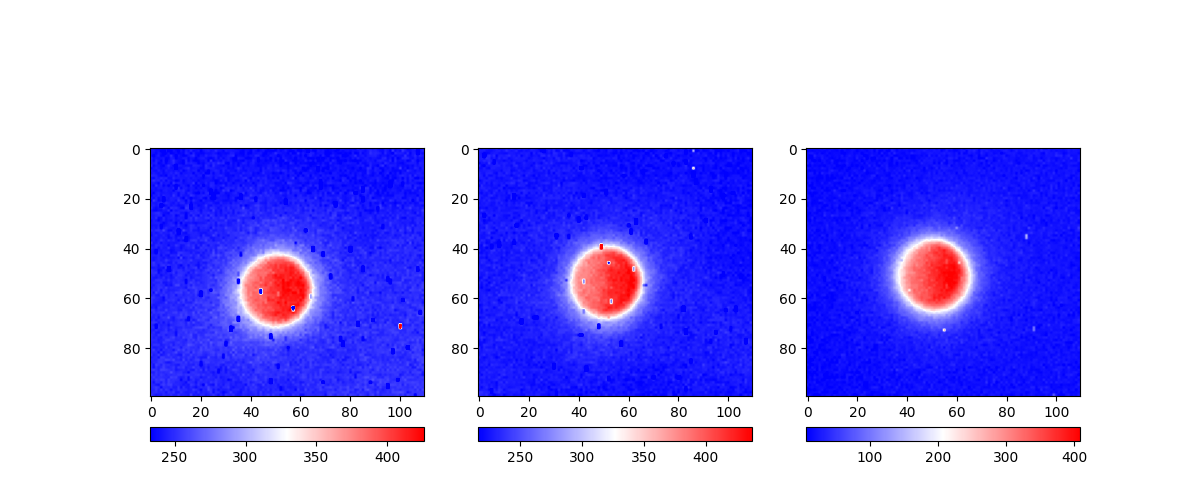

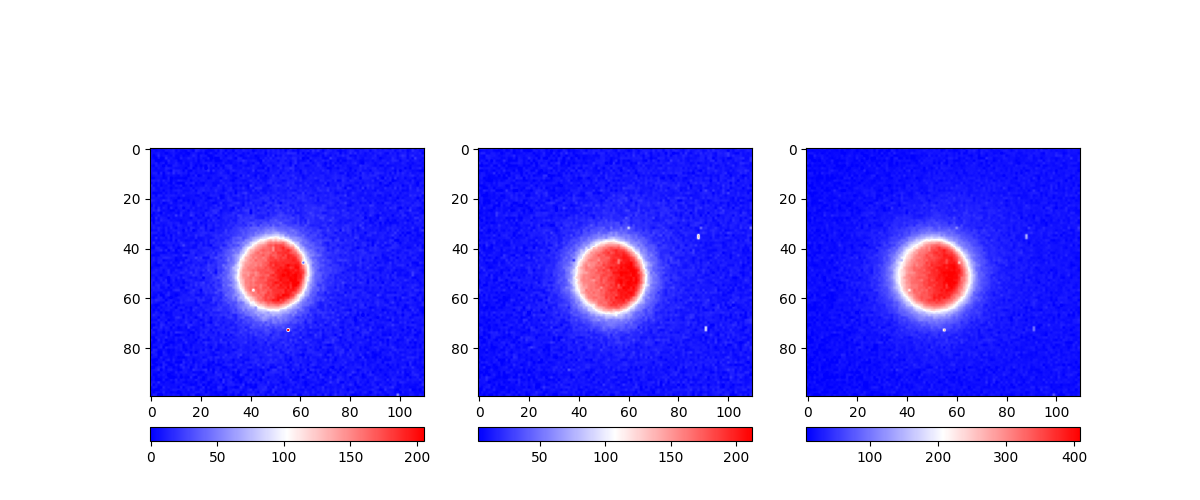

In [133]:
plot_ditherings(dither_kch4_1.data, dither_kch4_2.data, dither_kch4)
plot_ditherings(dither_kch4_3.data, dither_kch4_4.data, dither_kch4)

In [109]:
dither_feII = red_feII[0] - np.median(np.stack([red_feII[3], red_feII[4]]),axis=0)
dither_feII_2 = red_feII[3] - np.median(np.stack([red_feII[0], red_feII[4]]),axis=0)
dither_feII_3 = red_feII[1][:,:210] - np.median(np.stack([red_feII[i][:,:210] for i in [0,2,3,4]]),axis=0)
dither_feII_4 = red_feII[2][:,:210] - np.median(np.stack([red_feII[i][:,:210] for i in [0,1,3,4]]),axis=0)


dreg_feII = [(80,180),(370,480)]
dreg2_feII = [(380,480),(375,485)]
dreg3_feII = [(90,190),(70,180)]
dreg4_feII = [(390,490),(75,185)]


dither_feII_1 = dither_feII[dreg_feII[0][0]:dreg_feII[0][1], dreg_feII[1][0]:dreg_feII[1][1]]
dither_feII_2 = dither_feII_2[dreg2_feII[0][0]:dreg2_feII[0][1], dreg2_feII[1][0]:dreg2_feII[1][1]]
dither_feII_3 = dither_feII_3[dreg3_feII[0][0]:dreg3_feII[0][1], dreg3_feII[1][0]:dreg3_feII[1][1]]
dither_feII_4 = dither_feII_4[dreg4_feII[0][0]:dreg4_feII[0][1], dreg4_feII[1][0]:dreg4_feII[1][1]]

dither_feII_1 = np.ma.masked_where((0 > dither_feII_1 ) | (dither_feII_1 > 1), dither_feII_1)
dither_feII_2 = np.ma.masked_where((0 > dither_feII_2 ) | (dither_feII_2 > 1), dither_feII_2)
dither_feII_3 = np.ma.masked_where((0 > dither_feII_3 ) | (dither_feII_3 > 1), dither_feII_3)
dither_feII_4 = np.ma.masked_where((0 > dither_feII_4 ) | (dither_feII_4 > 1), dither_feII_4)


dither_feII = dither_feII_1.data + dither_feII_2.data + dither_feII_3.data + dither_feII_4.data

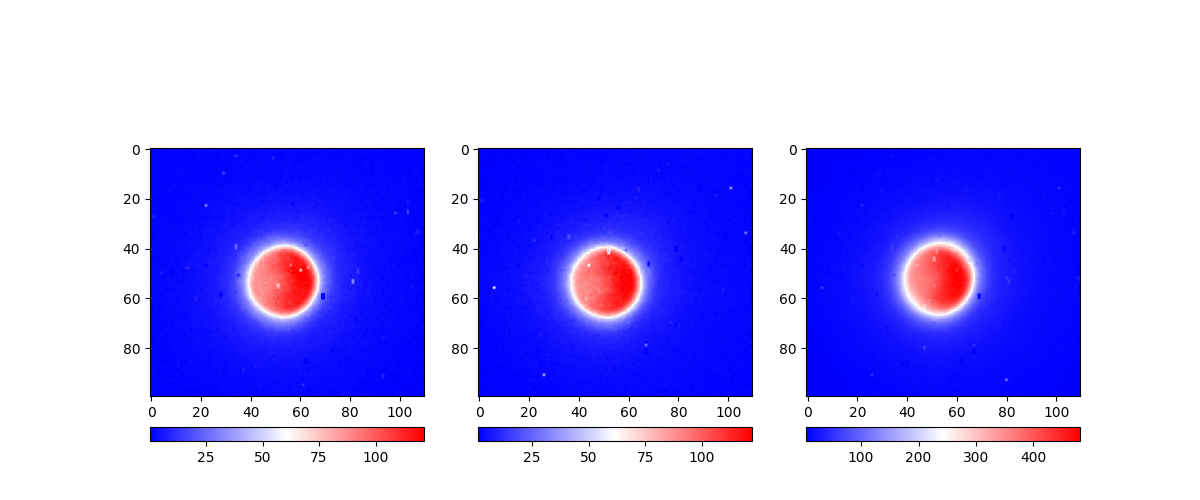

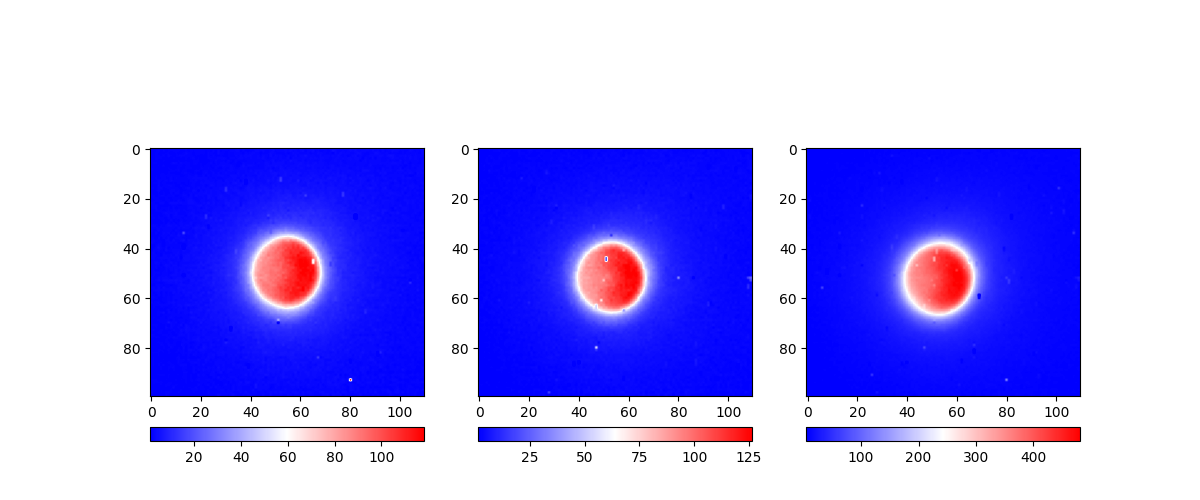

In [110]:

plot_ditherings(dither_feII_1.data, dither_feII_2.data, dither_feII)
plot_ditherings(dither_feII_3.data, dither_feII_4.data, dither_feII)

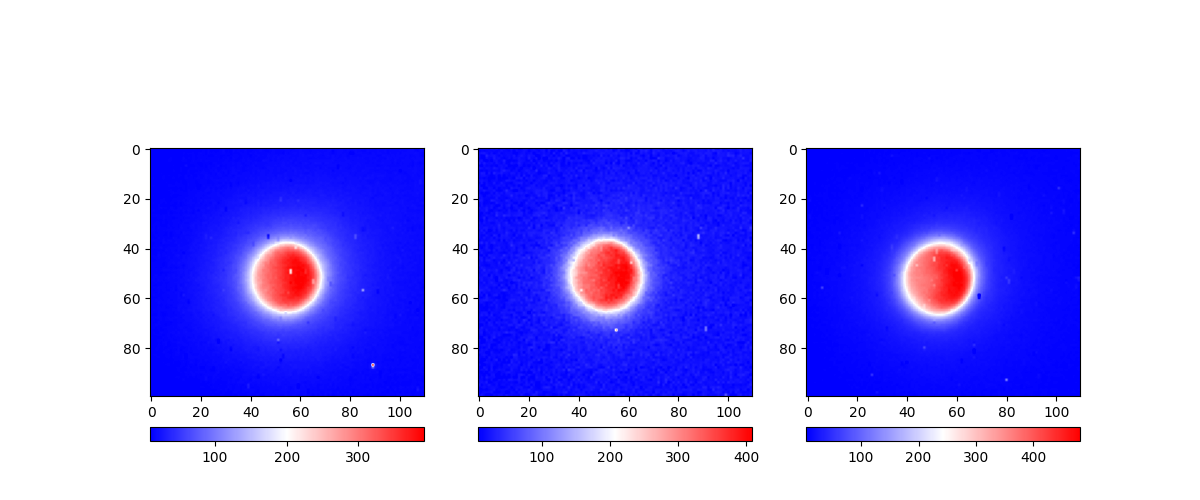

In [178]:
plot_ditherings(dither_jch4, dither_kch4,dither_feII)

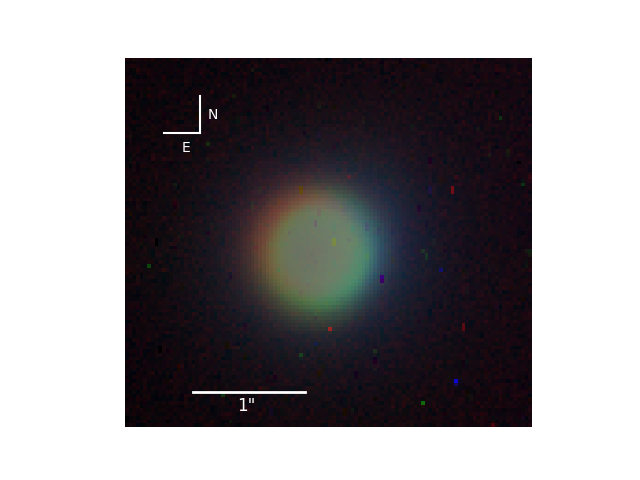

In [187]:
from astropy.visualization import make_lupton_rgb
dither_jch4, dither_kch4,dither_feII
image = make_lupton_rgb(dither_kch4, dither_feII, dither_jch4, stretch=250) # 250
plt.figure()
plt.imshow(image)

### Compass
y0n = 10
yn = np.linspace(y0n,y0n+10,100 )
xn = [20]*len(yn)
plt.plot(xn,yn,c='w')

xe = np.linspace(10,20,100)
ye = [20]*len(xe)
plt.plot(xe,ye,c='w')

plt.text(22,16,'N',c='w')
plt.text(15,25,'E',c='w')

# Image scale bar
x0s = 18
plate_scale = 0.033 # arcsec/pixel plate scale of Shane Telescope
x_w = 1/plate_scale
xs = np.linspace(x0s, x0s + x_w,1000)
ys = [90]*len(xs)
plt.plot(xs,ys,c='w',linewidth=2)
plt.text(30,95,'1"',c='w',size=12)

plt.plot(20,20,c='y')
plt.gca().axis('off')
plt.savefig("Titan_AO.pdf",bbox_inches="tight")

In [ ]:
# fits.writeto('titan_jch4.fits', dither_jch4[freg_jch4[0][0]:freg_jch4[0][1],freg_jch4[1][0]:freg_jch4[1][1]],overwrite=True)
# fits.writeto('titan_kch4.fits', dither_kch4[freg_kch4[0][0]:freg_kch4[0][1],freg_kch4[1][0]:freg_kch4[1][1]],overwrite=True)
# fits.writeto('titan_feII.fits', dither_feII[freg_feII[0][0]:freg_feII[0][1],freg_feII[1][0]:freg_feII[1][1]],overwrite=True)

In [135]:
fits.writeto('titan_jch4.fits', dither_jch4,overwrite=True)
fits.writeto('titan_kch4.fits', dither_kch4,overwrite=True)
fits.writeto('titan_feII.fits', dither_feII,overwrite=True)